# PA004 - HEALTH INSURANCE CROSS-SELL

## 0 - IMPORTS

In [1]:
import warnings
import random
import pickle

import pandas                as pd
import numpy                 as np
import seaborn               as sns
import scikitplot            as skplt
import plotly.express        as px
import matplotlib.patches    as mpatches

from IPython.core.display    import HTML
from IPython.display         import Image
from xgboost                 import XGBClassifier
from xgboost                 import XGBRegressor
from collections             import Counter
from catboost                import CatBoostClassifier

from scipy                   import stats                     as ss
from matplotlib              import pyplot                    as plt
from sklearn                 import preprocessing             as pp
from sklearn                 import model_selection           as ms
from sklearn                 import ensemble                  as en
from sklearn                 import neighbors                 as nh
from sklearn                 import linear_model              as lm

warnings.filterwarnings('ignore')

C:\Users\perot\anaconda3\envs\health_insurance_venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 0.1 - Helper Functions

In [2]:
def recall_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 

def precision_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def cramer_v( x, y):
    cm = pd.crosstab( x, y).values   
    n = cm.sum()
    r, k = cm.shape    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1) 
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def cross_validation(kfold, modelName, model, data, at_k):
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold[cols_selected]
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold[cols_selected]
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def ml_performance( model_name, precision_atK, recall_atK ):
    
    return pd.DataFrame( {'Model Name': model_name,
                          'Precision_at_K': precision_atK,
                          'Recall_at_K': recall_atK}, index=[0])

In [3]:
sns.set_theme()

## 1 - DATAS

In [4]:
# Linux
#df = pd.read_csv('/home/reng/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

# Train Datas - Windows
df = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

# Test Datas - Windows
#df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/test.csv')

### 1.2 - Data Description

#### 1.2.1 - Data Dimensions

In [ ]:
df.shape

In [ ]:
df.head()

#### 1.2.2 - Data Types

In [ ]:
df.dtypes

#### 1.2.3 - Check NA

In [ ]:
df.isna().sum()

#### 1.2.4 - Data Descriptive

In [ ]:
df['vehicle_age'].unique()

In [ ]:
num_attributes = df.select_dtypes( include=[ 'int32', 'int64', 'float64' ] )
cat_attributes = df.select_dtypes( exclude=[ 'object'] )

In [ ]:
num_attributes.hist(bins=25);

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

## 2 - FEATURE ENGINEERING

In [5]:
df2 = df.copy()

In [6]:
# Ajustando coluna vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else
                                                        2 if (x == '1-2 Year') else
                                                        3)
# Ajustando coluna vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

## 3 - DATA FILTERING

In [7]:
df3 = df2.copy()

## 4 - EDA

In [8]:
df4 = df3.copy()

### 4.1 -  Univariate Analysis

In [ ]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=45)
sns.set_theme(style="darkgrid")
sns.lineplot(data=df_bitcoin, x='date', y='price(USD)', color='red')

In [ ]:
# response
one = df4[['id','response']].groupby('response').count().reset_index()

plt.figure(figsize=(7,))
sns.barplot( x='response', y='id', data=one)

In [ ]:
# 'age'
plt.subplot(1,3,1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot(1,3,2)
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux1)

plt.subplot(1,3,3)
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

In [ ]:
# 'annual_premium'
plt.subplot(1,3,1)
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux)

plt.subplot(1,3,2)
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux1)

plt.subplot(1,3,3)
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

In [ ]:
# 'driving_license'
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()

plt.figure(figsize=(7,5))
sns.barplot( x='response', y='driving_license', data=aux)

In [ ]:
#'region_code'
aux = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
plt.figure(figsize=(7,5))
sns.scatterplot( x='region_code', y='id', hue='response', data=aux )

In [ ]:
# 'previously_insured'
pi = pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
pi_stack = pi.stack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(7,5))
sns.barplot( x= pi_stack.previously_insured, y= pi_stack.value, hue=pi_stack.response)

In [ ]:
#'gender'
gen = pd.crosstab( df4['gender'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
gen_stack = gen.stack().reset_index().rename(columns={0:'value'}) 
plt.figure(figsize=(7,5))
sns.barplot( x= gen_stack.gender, y= gen_stack.value, hue=gen_stack.response )

In [ ]:
# 'vehicle_age'
veh_age = df4[['vehicle_age','response']].value_counts( normalize=True ).reset_index()
veh_age = veh_age.rename(columns={0:'value'}) 
plt.figure(figsize=(7,5))
sns.barplot( x= veh_age.vehicle_age, y= veh_age.value, hue=veh_age.response )

In [ ]:
# 'vehicle_damage'
veh_dam = pd.crosstab( df4['vehicle_damage'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
veh_dam = veh_dam.stack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(7,5))
sns.barplot( x= veh_dam.vehicle_damage, y= veh_dam.value, hue=veh_dam.response )

In [ ]:
# 'policy_sales_channel'
# set the figure size
plt.figure(figsize=(25, 10))

# from raw value to percentage
total = df4.groupby('policy_sales_channel')['id'].count().reset_index()
response_1 = df4.loc[df4.response == 1 ].groupby('policy_sales_channel')['id'].count().reset_index()
response_0 = df4.loc[df4.response == 0 ].groupby('policy_sales_channel')['response'].sum().reset_index()
resp = pd.merge(response_1, response_0, how = 'outer', on = 'policy_sales_channel')
resp['id'] = resp['id'].fillna(0)
resp = resp.sort_values(by='policy_sales_channel')
resp['id'] = [i / j * 100 for i,j in zip(resp['id'], total['id'])]
total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="policy_sales_channel",  y="id", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="policy_sales_channel", y="id", data=resp, color='lightblue')

# add legend
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='darkblue', label='response = No')
bottom_bar = mpatches.Patch(color='lightblue', label='response = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [ ]:
# 'vintage'
plt.subplot( 1,3,1 )
sns.barplot( x='response', y='vintage', data=df4)

plt.subplot( 1,3,2 )
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

plt.subplot( 1,3,3 )
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

### 4.2 - Bivariate Analysis

In [ ]:
# 1. [GENDER] O percentual de homens que ja tiveram seu veiculo danificado é 30% maior do que o percentual de mulheres que já tiveram o carro danificado.

damage = df4[df4['vehicle_damage'] == 1]
damage = damage[['gender','vehicle_damage']].groupby('gender').count().reset_index()
damage['percentual'] = damage['vehicle_damage']/damage['vehicle_damage'].sum()*100
damage

In [ ]:
# 2. [GENDER] Os clientes homens são, na média, 5 anos mais velhos que clientes mulheres.
df4[['gender','age']].groupby('gender').mean().reset_index()

In [ ]:
# 3. [GENDER] Mulheres mais velhas tem carros mais novos.
hypo_3 = df2[df2['gender'] =='Female']
hypo_3[['age','vehicle_age']].groupby('vehicle_age').mean().reset_index()

In [ ]:
# 4. [GENDER] Mulheres tem maior interesse em adquirir seguro de automóveis.
df2[['gender','response','id']].groupby(['gender','response']).count().reset_index()

In [ ]:
# 5. [GENDER] O percentual de clientes sem carteira de motorista é maior em relação as mulheres do que em relação aos homens.
df2[['gender','driving_license','id']].groupby(['gender','driving_license']).count().reset_index()

In [ ]:
# 6. [AGE] Todos cliente com idade maior que 55 anos gostariam de adquirir seguro veicular.
hypo_6 = df2[(df2['age'] > 55)]

hypo_6[['response','id']].groupby('response').count().reset_index()

In [ ]:
# 7. [AGE] Clientes acima de 35 anos pagam 20% menos do que clientes com idade inferior.
one = df2[df2['age'] > 35]['annual_premium'].mean()
two = df2[df2['age'] < 35]['annual_premium'].mean()

print(one, two)
result = (one/two - 1)*100
result

In [ ]:
# 8. [AGE] 15% das pessoas com menos de 50 anos tem interesse em adquirir seguro.
q8 = df2[(df2['age']<=50)]
one = q8['id'].count()
two = q8[q8['response'] == 1]['id'].count()
result = (two/one)*100
result

In [ ]:
# 9. [AGE] 80% dos clientes com menos de 25 anos não tem interesse em adquirir seguro.
q9 = df2[(df2['age']<=25)]
one = q9['id'].count() 
two = q9[q9['response'] == 0]['id'].count()
result = (two/one)*100
result

In [ ]:
# 10. [VEHICLE DAMAGE] 70% dos clientes que ja danificaram seu carro tem menos de 30 anos.
q10 = df2[(df2['vehicle_damage']==1)]
one = q10[q10['age']<= 30]['id'].count()
two = q10['id'].count()
result = (one/two)*100
result

In [ ]:
# 11. [VEHICLE DAMAGE] 25% das pessoas que já danificaram seu carro antes pretendem assinar seguro de automovel.
q11 = df2[(df2['vehicle_damage']==1)]
one = q11[q11['response'] == 1]['id'].count()
two = q11['id'].count()
result = (one/two)*100
result

In [ ]:
# 12. [VEHICLE DAMAGE] Clientes que danificaram seu veiculo representam 40% da base de dados.
one = df2[df2['vehicle_damage'] == 0]['id'].count()
two = df2['id'].count()
result = (one/two)*100
result

In [ ]:
# 13. [VEHICLE DAMAGE] 30% dos carros mais antigos ja foram danificados antes.
q13 = df2[(df2['vehicle_age']==2)]
one = q13[q13['vehicle_damage']==1]['id'].count()
two = df2['id'].count()
result = (one/two)*100 
result

In [ ]:
# 14. [VEHICLE DAMAGE] 70% dos carros danificados tem interesse em fechar seguro.
q14 = df4[(df4['vehicle_damage']==1)]
one = q14[q14['response']==1]['id'].count()
two = q14['id'].count()
result = (one/two)*100 
result

In [ ]:
#15. [DRIVING LICENSE] 5% dos clientes sem licença para dirigir tem interesse no seguro de automóvel.
q15 = df2[(df2['driving_license'] == 0 )]
one = q15[q15['response']==1]['id'].count()
two = q15['id'].count()
result = (one/two)*100
result

In [ ]:
#16. [DRIVING LICENSE] Clientes com licença pagam mais.
df2[['driving_license','annual_premium']].groupby('driving_license').mean().reset_index()

In [ ]:
#17. [VEHICLE AGE] Quanto mais velho o veículo, menor o interesse em assinar seguro automóvel.
df17 = df2[(df2['response']==1)]
q17 = df17[['vehicle_age','id']].groupby('vehicle_age').count().reset_index()
plt.figure(figsize=(7,5))
plt.bar(q17['vehicle_age'],q17['id'])

In [ ]:
#18. [DRIVER LICENSE] Pessoas sem carteira de motorista pagam 25% mais.
q18 = df2[['driving_license','annual_premium']].groupby('driving_license').mean().reset_index()


fig = px.bar(q18, x='driving_license', y='annual_premium', color='annual_premium', text='annual_premium', height=450)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Pessoas sem carteira de motorista pagam 25% mais.", title_x=0.45)
fig.show()

In [ ]:
#19. [VEHICLE_DAMAGE] Clientes que já danificaram o carro, pagam 5% mais.
q19 = df2[['vehicle_damage','annual_premium']].groupby('vehicle_damage').mean().reset_index()


fig = px.bar(q19, x='vehicle_damage', y='annual_premium', color='annual_premium', text='annual_premium', height=450)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Clientes que já danificaram o carro, pagam mais.", title_x=0.45)
fig.show()

In [ ]:
#20. [VINTAGE] Clientes mais antigos pagam 10% menos.
bins = list( np.arange(0, 299, 30) )
#df2['vintage_culture'] = pd.cut( df2['vintage'], bins=bins )
aux2 = df2[['vintage','annual_premium']].groupby('vintage').mean().reset_index()
aux2

### 4.3 - Multivariate Analysis

#### 4.3.1 - Numerical Attributes

In [ ]:
# Only numerical datas
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### 4.3.2 - Categorical Attributes

In [ ]:
# Only categorical data
a = df1.select_dtypes( include='object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )

a3 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a4 = cramer_v( a['vehicle_age'], a['gender'] )

# Final DataSet

d = pd.DataFrame( {'gender': [a1, a2],
                   'vehicle_age': [a3, a4]
                  })

d = d.set_index( d.columns )

# Heatmap
sns.heatmap( d, annot=True )

## 5 - DATA PREPARATION

In [9]:
df5 = df4.copy()

### 5.1 - Split Dataset

In [10]:
# UNBALANCED
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_training, x_valid, y_training, y_valid = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat([ x_training, y_training ], axis=1 )

### 5.3 - Standardization

#### 5.3.1 - Unbalanced

In [11]:
# Subtrai-se a media e divide-se pelo desvio padrao

# annual premium
ss = pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump(ss, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/annual_premium_scaler.pkl', 'wb'))

### 5.4 - Rescaling

#### 5.4.1 - Unbalanced

In [12]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump(mms_age, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/age_scaler.pkl', 'wb'))
# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump(mms_vintage, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/vintage_scaler.pkl', 'wb'))

### 5.5 - Encoder

In [13]:
# gender
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding / Weighted Targed Encoding
target_encode_region_code = df5.groupby( 'region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_region_code_scaler.pkl', 'wb'))

# policy_sales_channel - Frequency Encoding / Target Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_policy_sales_scaler.pkl', 'wb'))

### 5.5 - Validation Preparation

In [14]:
# gender
x_valid.loc[:,'gender'] = x_valid.loc[:, 'gender'].map( target_encode_gender )

# age
x_valid.loc[:, 'age'] = mms_age.transform( x_valid[['age']].values )

# region code
x_valid.loc[:, 'region_code'] = x_valid.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle age
# x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# annual premium
x_valid.loc[:, 'annual_premium'] = ss.transform( x_valid[['annual_premium']].values )

# policy sales channel
x_valid.loc[:, 'policy_sales_channel'] = x_valid['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_valid.loc[:, 'vintage'] = mms_vintage.transform( x_valid[['vintage']].values )

#fillna
x_valid = x_valid.fillna( 0 )

## 6 - FEATURE SELECTION

### 6.1 - Feature Importance

In [15]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators =250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n  = y_training.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                feature  importance
0               vintage    0.278961
0        annual_premium    0.248023
0                   age    0.158166
0           region_code    0.104246
0        vehicle_damage    0.074644
0  policy_sales_channel    0.059153
0    previously_insured    0.053953
0           vehicle_age    0.016722
0                gender    0.005651
0       driving_license    0.000482


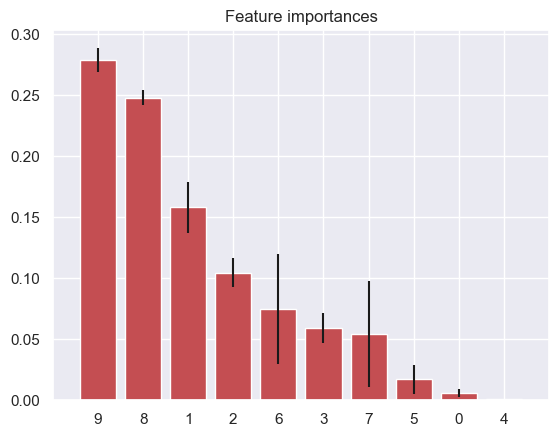

In [16]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the feature ranking 
print("Feature ranking:")
df = pd.DataFrame()
for i,j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis = 0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 7 - MACHINE LEARNING

In [17]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_training = df5[ cols_selected ]
x_validation = x_valid[ cols_selected ]
y_validation = y_valid.copy()

### 7.1 - XGB

In [18]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit( x_training, y_training )

# model prediction - The generalization POWER
yhat_xgb = xgb_model.predict_proba( x_validation )

# Accumulative Gain
#skplt.metrics.plot_cumulative_gain( y_validation, yhat_xgb, title='Comulative Gain - XGB' );

[20:49:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
yhat_xgb

array([[9.9989367e-01, 1.0631161e-04],
       [9.9913049e-01, 8.6954056e-04],
       [8.1434113e-01, 1.8565886e-01],
       ...,
       [8.0989206e-01, 1.9010793e-01],
       [8.1774998e-01, 1.8224999e-01],
       [9.2627388e-01, 7.3726125e-02]], dtype=float32)

In [20]:
x_valid['prediction'] = 

In [25]:
x_valid.sort_values('prediction', ascending=False)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,prediction
283302,358181,0.103822,0.676923,0.096268,0.004848,1,2,1,0,3.146876,0.211073,0.738418
108899,107167,0.138062,0.646154,0.186552,0.209117,1,2,1,0,3.486156,0.249135,0.729599
100202,36986,0.103822,0.553846,0.186552,0.209117,1,2,1,0,3.504065,0.719723,0.725156
12089,97292,0.138062,0.523077,0.186552,0.209117,1,2,1,0,3.481504,0.373702,0.699573
112832,138664,0.138062,0.476923,0.186552,0.209117,1,2,1,0,3.735252,0.761246,0.684862
...,...,...,...,...,...,...,...,...,...,...,...,...
18445,147383,0.103822,0.030769,0.062918,0.353233,1,1,0,1,0.632887,0.166090,0.000027
104115,68380,0.138062,0.738462,0.186552,0.000013,1,2,0,1,-0.288200,0.982699,0.000027
182081,312389,0.138062,0.707692,0.062918,0.000056,1,2,0,1,0.303084,0.750865,0.000024
122194,213128,0.138062,0.015385,0.062918,0.353233,1,1,0,1,1.113868,0.709343,0.000024


In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

### 7.2 - KNN

In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model.fit( x_training, y_training )

# model prediction - The generalization POWER
yhat_knn = knn_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axs[0],title='Cumulative Gain - KNN');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn,ax=axs[1],title='Lift Curve - KNN');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_knn, ax=axs[2], title='ROC-Curve - KNN');

plt.tight_layout()

### 7.3 - Logistic Regression

In [ ]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit( x_training, y_training )

# model prediction - The Generalization POWER
yhat_lr_model = lr_model.predict_proba( x_validation )

In [ ]:
yhat_lr_model

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr_model, ax=axs[0],title='Cumulative Gain - Linear Regression');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lr_model,ax=axs[1],title='Lift Curve - Linear Regression');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lr_model, ax=axs[2], title='ROC-Curve - Linear Regression');

plt.tight_layout()

### 7.4 - Extra Trees

In [ ]:
# model definition
et_model = en.ExtraTreesClassifier( n_estimators=200, n_jobs=-1, random_state=42 )

# model training
et_model.fit( x_training, y_training )

# model prediction - The Generalization POWER
yhat_et_model = et_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_et_model, ax=axs[0],title='Cumulative Gain - Extra Trees');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_et_model,ax=axs[1],title='Lift Curve - Extra Trees');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_et_model, ax=axs[2], title='ROC-Curve - Extra Trees');

plt.tight_layout()

### 7.5 - Randon Forest

In [ ]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators=2000, n_jobs=-1, random_state=42 )

# model training
rf_model.fit( x_training, y_training )

# model prediction - The Generalization POWER
yhat_rf_model = rf_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf_model, ax=axs[0],title='Cumulative Gain - Randon Forest');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_rf_model,ax=axs[1],title='Lift Curve - Randon Forest');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_rf_model, ax=axs[2], title='ROC-Curve - Randon Forest');

plt.tight_layout()

### 7.6 - Catboost Classifier

In [ ]:
# model definition
cb_model = CatBoostClassifier(
    iterations = 1000, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 7,
    l2_leaf_reg = 5,
    learning_rate=0.03,
    bagging_temperature = 0.5,
    task_type = "GPU",
)

# model training
cb_model.fit(x_training, y_training)

# model prediction
yhat_cb_model = cb_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_cb_model, ax=axs[0],title='Cumulative Gain - CatBoost');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_cb_model,ax=axs[1],title='Lift Curve - CatBoost');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_cb_model, ax=axs[2], title='ROC-Curve - CatBoost');

plt.tight_layout()

## 8 - MODEL PERFORMANCE

### 8.1 - KNN Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_knn[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

KNN_performance = ml_performance('KNN_Model', precision_atK, recall_atK )
KNN_performance

### 8.2 - Logistic Regression Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_lr_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )


# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

lr_performance = ml_performance('LR Model', precision_atK, recall_atK )
lr_performance

### 8.3 - Extra Trees Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_et_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

et_performance = ml_performance('ET Model', precision_atK, recall_atK )
et_performance

### 8.4 - Random Forest Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_rf_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

rf_performance = ml_performance('RF Model', precision_atK, recall_atK )
rf_performance

### 8.5 -  XGB Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_xgb[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

xgb_performance = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance

### 8.6 - CatBoost Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_cb_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

cb_performance = ml_performance('CB Model', precision_atK, recall_atK )
cb_performance

### 8.7 - Results for all models

In [ ]:
model_performance = pd.concat( [KNN_performance, lr_performance, et_performance, rf_performance, xgb_performance, cb_performance] )
model_performance.sort_values('Precision_at_K', ascending= False)

## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - Cross Validation

In [ ]:
# Concatenation train and validation dataset to use in cross-validation
#df_cv = x_training.copy()
#df_cv['response'] = y_training

#df_aux = x_valid.copy()
#df_aux['response'] = y_valid

#df_cc = pd.concat([df_cv, df_aux])

In [ ]:
# Dictioary with models instantiated
#models = { 'KNN': knn_model,
#         'Logistic Regression': lr_model,
#         'Random Forest': rf_model,
#         'XGB Model': xgb_model,
#         'Ext. Model': et_model,
#         'RF Model': rf_model,
#         'CB Model': cb_model }
#
# Cross-validated models performance
#model_performance = pd.DataFrame()

#for key in models.keys():
#    performance_cv = cross_validation(5, key, models[key], df_cc, 20000)
#    model_performance = pd.concat([model_performance, performance_cv], axis=1)

#model_performance.T

In [ ]:
# Tabela com resultado do crossvalidation salvo na maquina.
cv_result = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/processed/crossvalidationresult.csv')
cv_result.sort_values('recall_at_k', ascending=False)

### 9.2 - XGB Fine Tuning

In [ ]:
#param = {
#     'n_estimators': [1000, 1500, 2000, 2500], 
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight':[3, 8, 15] }

#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
# choose values for parameters randomly
#    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = XGBClassifier(colsample_bytree =hp['colsample_bytree'],
#                               subsample = hp['subsample'],
#                               objective='binary:logistic', 
#                               n_estimators=hp['n_estimators'], 
#                               max_depth=hp['max_depth'],
#                               min_child_weight = hp['min_child_weight'],
#                               eta=hp['eta'])
#    # performance
#    result = cross_validation(2, 'xgb classifier', xgb_model, df_cc, 20000)
#    final_result = pd.concat( [final_result, result] )
#
#final_result

### 9.3 - CatBoost Fine Tuning

In [ ]:
#param = {
#     'iterations': [1000, 1500, 2000, 2500], 
#     'leaf_estimation_iterations': [100, 150, 200],
#     'depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'random_strength': [0.3, 0.7, 0.9],
#     'l2_leaf_reg':[3, 8, 15],
#     'learning_rate':[0.01, 0.03, 0.05]}
#
# MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = CatBoostClassifier(
#                        iterations = hp['iterations'],
#                        loss_function='MultiClass',
#                        bootstrap_type = "Bayesian",
#                        eval_metric = 'MultiClass',
#                        leaf_estimation_iterations = hp['leaf_estimation_iterations'],
#                        random_strength = hp['random_strength'],
#                        depth = hp['depth'],
#                        l2_leaf_reg = hp['l2_leaf_reg'],
#                        learning_rate= hp['learning_rate'],
#                        bagging_temperature = 0.5,
#                        task_type = "GPU" )
#    # performance
#    result = cross_validation(2, 'catboost classifier', cb_model, df_cc, 20000)
#    final_result = pd.concat( [final_result, result] )
#
#final_result

### 9.4 - XGB Classifier after Tuning

In [ ]:
# XGB CROSS VALIDATION

# model definition
model_xgb_cv = XGBClassifier( colsample_bytree = 0.3,
                              subsample = 0.7,
                              objective='binary:logistic', 
                              n_estimators=2000, 
                              max_depth= 5,
                              min_child_weight = 8,
                              eta= 0.03 )

# model training
model_xgb_cv.fit( x_training, y_training )

# model prediction - The generalization POWER
yhat_xgb_cv = model_xgb_cv.predict_proba( x_validation )

In [ ]:
pickle.dump(model_xgb_cv, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/models/xgb_model.pkl', 'wb'))

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb_cv, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb_cv,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_xgb_cv, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_xgb_cv[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

xgb_performance_cv = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance_cv

### 9.5 - CatBoost Classifier after tuning

In [ ]:
# model definition
cb_model_cv = CatBoostClassifier(
    iterations = 1500, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 150,
    random_strength = 0.7,
    depth = 5,
    l2_leaf_reg = 3,
    learning_rate=0.03,
    bagging_temperature = 0.5,
    task_type = "GPU",
)

# model training
cb_model_cv.fit(x_training, y_training)

# model prediction
yhat_cb_model_cv = cb_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_cb_model_cv, ax=axs[0],title='Cumulative Gain - CatBoost');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_cb_model_cv,ax=axs[1],title='Lift Curve - CatBoost');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_cb_model_cv, ax=axs[2], title='ROC-Curve - CatBoost');

plt.tight_layout()

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_cb_model_cv[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

cb_performance_cv = ml_performance('CB Model', precision_atK, recall_atK )
cb_performance_cv

### 9.3 - ML Models Performance - After Fine Tunning

In [ ]:
model_performance = pd.concat( [xgb_performance_cv, cb_performance_cv] )
model_performance.sort_values('Precision_at_K', ascending= False)

## 10 - DEPLOY MODEL TO PRODUCTION

### 10.1 - HealthInsurance Class

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                            = ''
        self.annual_premium_scaler                = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb') )
        self.age_scaler                           = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.vintage_scaler                       = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.target_encode_region_code_scaler     = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler          = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.frequency_encode_policy_sales_scaler = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
     
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def data_preparation( self, df5 ):   
        
        # Ajustando coluna vehicle_age
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)
        
        # Ajustando coluna vehicle_damage
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
       
        # Age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
    
        # Annual Premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
        
        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # codigo de regiao
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )
        
        # policy_sales_channel - Frequency Encoding / Target Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )
        
        # Feature Selection
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

        return df5[cols_selected]

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API Handler

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.data_preparation( df1 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df2 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

### 10.3 - API Tester

In [37]:
import requests
import pandas as pd

In [38]:
# Load Datasets
df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/test.csv')

In [39]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11,1,< 1 Year,No,35786,152,53
1,381111,Male,40,1,28,0,1-2 Year,Yes,33762,7,111
2,381112,Male,47,1,28,0,1-2 Year,Yes,40050,124,199
3,381113,Male,24,1,27,1,< 1 Year,Yes,37356,152,187
4,381114,Male,27,1,28,1,< 1 Year,No,59097,152,297


In [40]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [46]:
 # API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'http://127.0.0.1:5000/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /healthinsurance/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001810F763220>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [45]:
d2 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d2.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
97810,478920,0.103550,0.369231,1,0.186886,0,3,1,4.481925,0.209218,0.089965,0.694340
118488,499598,0.138271,0.353846,1,0.186886,0,2,1,4.556858,0.007521,0.228374,0.629489
35616,416726,0.138271,0.307692,1,0.186886,0,2,1,4.516429,0.209218,0.788927,0.628856
50787,431897,0.138271,0.584615,1,0.186886,0,3,1,4.485004,0.209218,0.740484,0.620856
50162,431272,0.138271,0.200000,1,0.121179,0,1,1,-0.298866,0.007521,0.764706,0.585072
